In [1]:
import torch 
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib
import pyro
torch.manual_seed(0)

Define prior on $\theta$

In [2]:
sigma_theta = .5
mu_theta = 0
prior_distribution = torch.distributions.MultivariateNormal(torch.ones(1)*mu_theta, torch.eye(1)*sigma_theta) 

Generate $D_\theta$ according to some prior distribution

In [3]:
n_D = 100
D_theta = torch.linspace(-1,1,n_D).unsqueeze(-1)

Generate $D_x$ according to some unknown data generating process

In [4]:
sigma_simulateur = 10
N_simulateur = 100
def summary_statistics(x):
    return torch.stack([torch.mean(x, dim = -1), torch.std(x, dim = -1)], dim = -1)
def simulator(theta, sigma=0):
    u = torch.randn(theta.shape[0],N_simulateur)*sigma_simulateur + theta
    z = torch.randn(theta.shape[0],N_simulateur)
    temp = u+sigma*z
    return temp
D_x = summary_statistics(simulator(D_theta, 0))
print(D_x.shape)

torch.Size([100, 2])


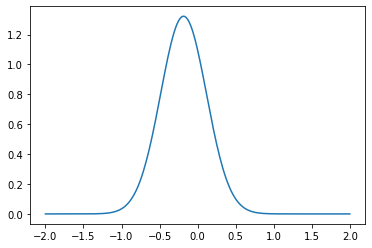

In [5]:
theta_0 = torch.tensor([0])
n_x0 = 10
x0 = simulator(theta_0.unsqueeze(0).repeat(n_x0,1))
sigma2_n = (1 + (n_x0*x0.shape[-1])/(sigma_simulateur**2))**(-1)
mu_n = sigma2_n*(torch.sum(x0)/(sigma_simulateur**2))
true_posterior= torch.distributions.MultivariateNormal(torch.tensor([mu_n]), torch.tensor([[sigma2_n]]))
tt = torch.linspace(-2,2, 200)
plt.plot(tt, torch.exp(true_posterior.log_prob(tt.unsqueeze(-1))))
true_posterior_samples = torch.distributions.MultivariateNormal(torch.tensor([mu_n]), torch.tensor([[sigma2_n]])).sample([1000])
x0 = summary_statistics(x0)

Generate $x_0$ according to $f(\theta_0)$ for some unknown $\theta_0$

In [6]:
import sys
sys.path.append('..')
from conditional_density_estimators import ConditionalDIFDensityEstimator
dif = ConditionalDIFDensityEstimator(D_x, D_theta, 2, [32,32])
epochs = 1000
batch_size = 50
dif.train(epochs,batch_size, lr = 1e-3)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.14it/s, loss = 1.239771 ; device: cpu]


In [7]:
from __future__ import division
import numpy as np
import scipy.stats
import torch

def hpd_grid(sample, alpha=0.05, roundto=2):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI). 
    The function works for multimodal distributions, returning more than one mode
    Parameters
    ----------
    
    sample : Numpy array or python list
        An array containing MCMC samples
    alpha : float
        Desired probability of type I error (defaults to 0.05)
    roundto: integer
        Number of digits after the decimal point for the results
    Returns
    ----------
    hpd: array with the lower 
          
    """
    temp = np.asarray(sample)
    temp = temp[~np.isnan(temp)]
    # get upper and lower bounds
    l = np.min(temp)
    u = np.max(temp)
    density = scipy.stats.gaussian_kde(temp, 'scott')
    x = np.linspace(l, u, 2000)
    y = density.evaluate(x)
    xy_zipped = zip(x, y/np.sum(y))
    xy = sorted(xy_zipped, key=lambda x: x[1], reverse=True)
    xy_cum_sum = 0
    hdv = []
    for val in xy:
        xy_cum_sum += val[1]
        hdv.append(val[0])
        if xy_cum_sum >= (1-alpha):
            break
    hdv.sort()
    diff = (u-l)/20  # differences of 5%
    hpd = []
    hpd.append(round(min(hdv), roundto))
    for i in range(1, len(hdv)):
        if hdv[i]-hdv[i-1] >= diff:
            hpd.append(round(hdv[i-1], roundto))
            hpd.append(round(hdv[i], roundto))
    hpd.append(round(max(hdv), roundto))
    ite = iter(hpd)
    hpd = list(zip(ite, ite))
    return hpd

def plot_expected_coverage(samples, posterior_samples, grid = 50):
    list_ = []
    for alpha in tqdm(range(0,grid+1)):
        hpd,= hpd_grid(samples, 1-alpha/grid)
        sum = 0
        for mode in hpd:
            sum +=((posterior_samples>mode[0])*(posterior_samples<mode[1])).float().mean()
        list_.append(sum.unsqueeze(0))
    plt.plot(torch.linspace(0,1,grid+1), torch.cat(list_).numpy())
    plt.plot(torch.linspace(0,1,grid+1),torch.linspace(0,1,grid+1), linestyle = '--')
    plt.show()

theta_0 = 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 51.31it/s, acceptance = tensor(0.4280)]


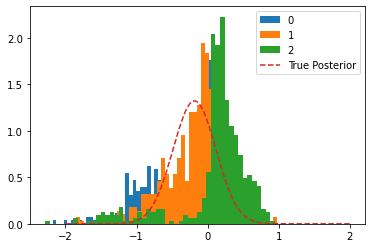

In [10]:
theta_0 = torch.tensor(0)
print('theta_0 = ' + str(theta_0.item()))
sample_list=[]
from samplers import ULA, IMH, HMC, MALA
for sigma in [0,1,2]:
    x0 = summary_statistics(simulator(theta_0.unsqueeze(0).repeat(n_x0, 1),sigma))
    posterior_log_prob = lambda theta: torch.sum(dif.log_density(x0.unsqueeze(0).repeat(theta.shape[0],1,1), theta.unsqueeze(1).repeat(1,n_x0,1)), dim = 1 ) + prior_distribution.log_prob(theta)
    sampler = IMH(posterior_log_prob,D_theta.shape[1],prior_distribution, 500)
    samples = sampler.sample(100)
    sample_list.append(samples)
    plt.hist(samples.numpy(), density = True, bins = 50,label = str(sigma))
plt.plot(tt, torch.exp(true_posterior.log_prob(tt.unsqueeze(-1))), linestyle = '--', label = 'True Posterior')
plt.legend()
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 43.16it/s]


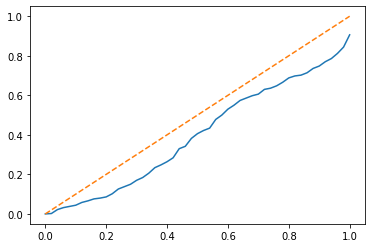

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 42.74it/s]


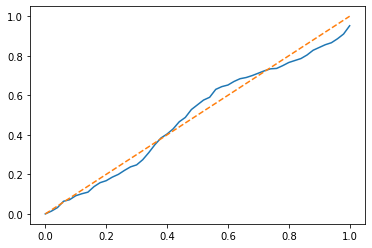

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 42.75it/s]


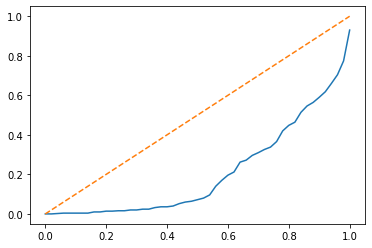

In [11]:
for i in [0,1,2]:
    plot_expected_coverage(true_posterior_samples,sample_list[i], grid = 50)

In [ ]:
current_theta=sample_list[-1]
for t in range(10):    
    D_x_plus = torch.cat([D_x, x0], dim = 0)
    D_theta_plus = torch.cat([D_theta, current_theta[:1].repeat(n_x0,1)], dim=0)
    dif = ConditionalDIFDensityEstimator(D_x_plus, D_theta_plus, 2,[32,32])
    dif.train(epochs,batch_size, 1e-3)
    
    posterior_log_prob = lambda theta: torch.sum(dif.log_density(x0.unsqueeze(0).repeat(theta.shape[0],1,1), theta.unsqueeze(1).repeat(1,n_x0,1)), dim = 1 ) + prior_log_prob(theta)
    sampler = IMH(posterior_log_prob, 1, prior_distribution, 500)
    current_theta = sampler.sample(50)
    plot_expected_coverage(true_posterior_samples,current_theta, grid = 50)
    